In [21]:
import pandas as pd
import os 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
from torch import  nn
from torchvision import transforms ,datasets
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler

from tqdm.notebook import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [22]:
class VARAutoencodersCNN(nn.Module):
    def __init__(self):
        super().__init__()

        #Encoder
        self.Conv1=nn.Conv2d(3,16,3)
        self.Conv2=nn.Conv2d(16,32,3)
        self.Conv3=nn.Conv2d(32,8,3)
        self.Conv4=nn.Conv2d(8,1,3)
        self.flat=nn.Flatten()
        self.Dense=nn.Linear(in_features=576,out_features=64)
        self.Dense2=nn.Linear(in_features=64,out_features=16)
        self.Mu=nn.Linear(in_features=16,out_features=10)
        self.Simga=nn.Linear(in_features=16,out_features=10)
        self.Relu=nn.ReLU()
        self.Sigmoid=nn.Sigmoid()

        #Decoder
        self.UNDense=nn.Linear(10,16)
        self.UNDense1=nn.Linear(16,64)
        self.UNDense2=nn.Linear(64,576)
        self.UNFlat=nn.Unflatten(1,(1,24,24))
        self.Unconv1=nn.ConvTranspose2d(1,8,3)
        self.Unconv2=nn.ConvTranspose2d(8,32,3)
        self.Unconv3=nn.ConvTranspose2d(32,16,3)
        self.Unconv4=nn.ConvTranspose2d(16,3,3)

    def Encoder(self,Dataset):
        x=self.Conv1(Dataset)
        x=self.Relu(x)
        x=self.Conv2(x)
        x=self.Relu(x)
        x=self.Conv3(x)
        x=self.Relu(x)
        x=self.Conv4(x)
        # print(x.shape)
        x=self.Relu(x)
        x=self.flat(x)
        # print(x.shape)
        x=self.Dense(x)
        x=self.Dense2(x)
        mu,sigma=self.Mu(x),self.Simga(x)
        return (mu,sigma)


    def Decoder(self,Dataset):
        x=self.UNDense(Dataset)
        x=self.Relu(x)
        x=self.UNDense1(x)
        x=self.Relu(x)
        x=self.UNDense2(x)
        x=self.Relu(x)
        x=self.UNFlat(x)
        x=self.Unconv1(x)
        x=self.Relu(x)
        x=self.Unconv2(x)
        x=self.Relu(x)
        x=self.Unconv3(x)
        x=self.Relu(x)
        x=self.Unconv4(x)
        x_recontructed=self.Sigmoid(x)
        return x_recontructed

    def forward(self,Dataset):
        mu,sigma=self.Encoder(Dataset)
        epsilon=torch.rand_like(sigma)
        z_parameterized=mu+sigma*epsilon
        x_recontructed=self.Decoder(z_parameterized)
        return (x_recontructed,mu,sigma)

In [23]:
LR_rate=3e-4
Num_epochs=20
batch_size=512
loss_val=[]
epochs_val=[]

In [24]:
TrainData=datasets.CIFAR10(root="/home/yash/CNN_Data",train=True,transform=transforms.ToTensor(),download=True)
TestData=datasets.CIFAR10(root="/home/yash/CNN_Data",train=False,transform=transforms.ToTensor(),download=True) 

TrainDataSet=DataLoader(TrainData,batch_size=batch_size)
TestDataSet=DataLoader(TestData,batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
vaeCnn=VARAutoencodersCNN().to(device)
Opt=Adam(vaeCnn.parameters(),lr=LR_rate)
loss_fn=nn.MSELoss()

In [26]:
for epochs in range(Num_epochs):
    loop=tqdm(enumerate(TrainDataSet),colour="Blue")

    for i, (x,_) in loop:
        x=x.to(device)
        x_recontructed,mu,sigma=vaeCnn(x)

        recontructed_loss=loss_fn(x_recontructed,x)
        kl_div=-torch.sum(1+torch.log(sigma.pow(2))-mu.pow(2)-sigma.pow(2))

        loss=recontructed_loss+kl_div

        Opt.zero_grad()
        loss.backward()
        Opt.step()
        
        loop.set_postfix(loss=loss.item(),epoch=epochs+1)
    loss_val.append(loss.item())
    epochs_val.append(epochs+1)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

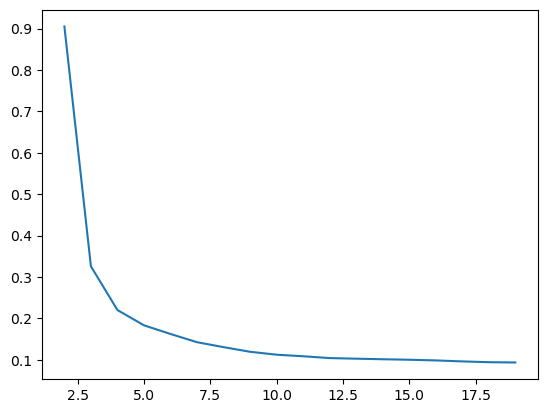

In [27]:
plt.plot(epochs_val[1:19],loss_val[1:19])